# Divvy Exploratory Data Analysis

Exploratory data analysis for Divvy bikesharing data from April 2020 to May 2023.

### Preliminaries

In [1]:
import pandas as pd
import os
from datetime import datetime
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
import plotly.express as px

In [2]:
colours = ['#D5573B','#074F57','#077187','#9ECE9A','#D7CEB2']
sns.set_palette(colours)

In [3]:
dtypes = {
    'ride_id': str,
    'rideable_type': str,
    'started_at': str,
    'ended_at': str,
    'start_station_name': str,
    'start_station_id': str,
    'end_station_name': str,
    'end_station_id': str,
    'start_lat': float,
    'start_lng': float,
    'end_lat': float,
    'end_lng': float,
    'member_casual': str,
    'time': float,
    'distance': float,
}

In [4]:
data_path = os.getcwd() + '/../data/data_dist_time.csv'
data = pd.read_csv(data_path, dtype=dtypes, index_col=0)

In [31]:
data['started_at'] = pd.to_datetime(data['started_at'])
data['ended_at'] = pd.to_datetime(data['ended_at'])
data['time'] = data['time'].div(60)

In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16031963 entries, 0 to 16048416
Data columns (total 18 columns):
 #   Column              Dtype         
---  ------              -----         
 0   ride_id             object        
 1   rideable_type       object        
 2   started_at          datetime64[ns]
 3   ended_at            datetime64[ns]
 4   start_station_name  object        
 5   start_station_id    object        
 6   end_station_name    object        
 7   end_station_id      object        
 8   start_lat           float64       
 9   start_lng           float64       
 10  end_lat             float64       
 11  end_lng             float64       
 12  member_casual       object        
 13  time                float64       
 14  distance            float64       
 15  year                int64         
 16  month               int64         
 17  hour                int64         
dtypes: datetime64[ns](2), float64(6), int64(3), object(7)
memory usage: 2.3+ GB


In [33]:
data['year'] = data['started_at'].dt.year
data['month'] = data['started_at'].dt.month
data['hour'] = data['started_at'].dt.hour

data.year = data.year.astype('int')
data.month = data.month.astype('int')
data.hour = data.hour.astype('int')

In [34]:
data.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,time,distance,year,month,hour
0,A847FADBBC638E45,docked_bike,2020-04-26 17:45:14,2020-04-26 18:12:03,Eckhart Park,86,Lincoln Ave & Diversey Pkwy,152,41.8964,-87.6610,41.9322,-87.6586,member,26.816667,2.473894,2020,4,17
1,5405B80E996FF60D,docked_bike,2020-04-17 17:08:54,2020-04-17 17:17:03,Drake Ave & Fullerton Ave,503,Kosciuszko Park,499,41.9244,-87.7154,41.9306,-87.7238,member,8.150000,0.608713,2020,4,17
2,5DD24A79A4E006F4,docked_bike,2020-04-01 17:54:13,2020-04-01 18:08:36,McClurg Ct & Erie St,142,Indiana Ave & Roosevelt Rd,255,41.8945,-87.6179,41.8679,-87.6230,member,14.383333,1.854582,2020,4,17
3,2A59BBDF5CDBA725,docked_bike,2020-04-07 12:50:19,2020-04-07 13:02:31,California Ave & Division St,216,Wood St & Augusta Blvd,657,41.9030,-87.6975,41.8992,-87.6722,member,12.200000,1.330589,2020,4,12
4,27AD306C119C6158,docked_bike,2020-04-18 10:22:59,2020-04-18 11:15:54,Rush St & Hubbard St,125,Sheridan Rd & Lawrence Ave,323,41.8902,-87.6262,41.9695,-87.6547,casual,52.916667,5.666709,2020,4,10


### Further Cleaning

In [35]:
data[['time', 'distance']].describe().apply(lambda s: s.apply(lambda x: format(x, 'g')))

,time,distance
count,1.6032e+07,1.6032e+07
mean,19.347,1.34395
std,207.583,4.48047
min,-29050,0
25%,6.33333,0.541596
50%,11.4,0.999052
75%,20.95,1.77824
max,58720,6100.2


We can remove some outliers, particularly when time is negative or absurdly high. The maximum time is 58,720 minutes—that's over 40 days! Let's filter out the top and bottom percentage of the data in terms of time.

In [36]:
lower = np.percentile(data['time'], 1)
upper = np.percentile(data['time'], 99)
cleaned = data[data.time.between(lower, upper)]
cleaned[['time', 'distance']].describe().apply(lambda s: s.apply(lambda x: format(x, 'g')))

,time,distance
count,1.57164e+07,1.57164e+07
mean,16.6744,1.35589
std,16.6612,4.24871
min,0.333333,0
25%,6.41667,0.559411
50%,11.4,1.01176
75%,20.65,1.7881
max,124.117,6100.2


Looks much better. However, the maximum distance of 6,100 miles is also a bit fishy, especially considering the maximum time is now just over 2 hours. That's nearly 3,000mph, more than five times faster than a commercial plane. Impressive, but probably not realistic. Chicago is about 25 miles at its greatest extent, so let's also filter out data points where the distances exceed 25 miles.

In [37]:
cleaned = cleaned[cleaned.distance < 25]
cleaned[['time', 'distance']].describe().apply(lambda s: s.apply(lambda x: format(x, 'g')))

,time,distance
count,1.57163e+07,1.57163e+07
mean,16.6744,1.35313
std,16.6612,1.20589
min,0.333333,0
25%,6.41667,0.559411
50%,11.4,1.01176
75%,20.65,1.7881
max,124.117,19.8114


In [38]:
cleaned2 = cleaned.replace({'docked_bike': 'classic_bike'}, regex=True)

<Axes: xlabel='distance', ylabel='Density'>

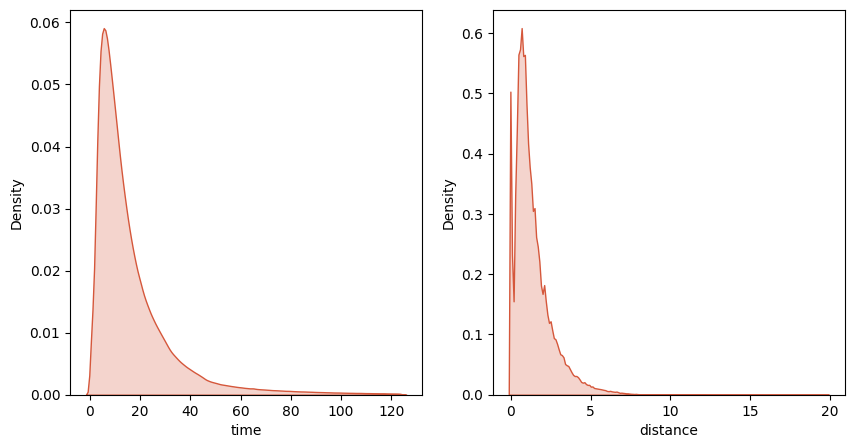

In [75]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
sns.kdeplot(data=cleaned2, x='time', fill=True, ax=axes[0])
sns.kdeplot(data=cleaned2, x='distance', fill=True, ax=axes[1])

# Analysis

I will perform the following analyses:

<u> Casual vs member analysis </u>
1. Usage time
    - Average time
2. Usage (by hour of day)
3. Usage (by month of year)
4. Distance rode
    - Average distance
5. Popular stations (starting and ending)
6. Bike type
7. Trip count

<u> Inter-year analysis (zoom in on 2021 vs 2022 quarters) </u>
1. Usage time
    - Casual vs member
    - Bike type
2. Trip count

<u> Inter-station analysis </u>
1. Casual vs member
2. Peak hours
3. Peak months
4. Trip count

Much of the analyses will be concentrated on the time rather than the distance as the distance travelled can be somewhat misleading. It is possible that riders pick up and dock at the same station, and the distance travelled metric does not capture this behaviour accurately. Also for this reason, I did not impose a lower bound on distance rode when cleaning the dataset in the previous section.

#### Casual vs member analysis

<Axes: xlabel='count', ylabel='year'>

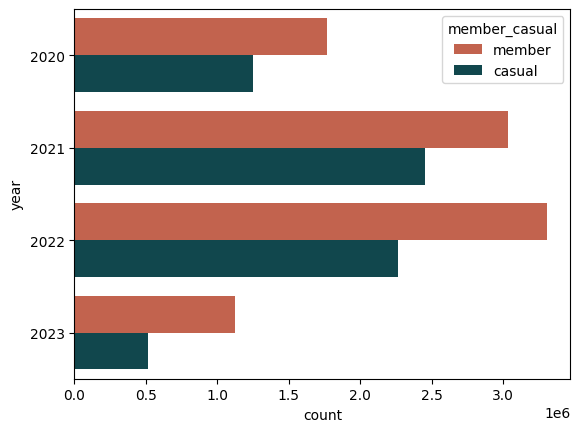

In [40]:
sns.countplot(data=cleaned2, y='year', hue='member_casual')

Throughout the past three years, there have been more member rides than casual rides, which is largely unsurprising.

In [41]:
cleaned2.groupby('member_casual')['time'].describe().apply(lambda s: s.apply(lambda x: format(x, 'g')))

,count,mean,std,min,25%,50%,75%,max
member_casual,,,,,,,,
casual,6.48409e+06,22.1773,21.1826,0.333333,8.46667,15.0333,27.55,124.117
member,9.23225e+06,12.8095,11.01,0.333333,5.51667,9.51667,16.5333,124.117


In [42]:
cleaned2.groupby('member_casual')['distance'].describe().apply(lambda s: s.apply(lambda x: format(x, 'g')))

,count,mean,std,min,25%,50%,75%,max
member_casual,,,,,,,,
casual,6.48409e+06,1.37743,1.24927,0,0.570009,1.05473,1.83324,19.8114
member,9.23225e+06,1.33605,1.17416,0,0.55423,0.978693,1.75399,19.5928


<Axes: xlabel='time', ylabel='Density'>

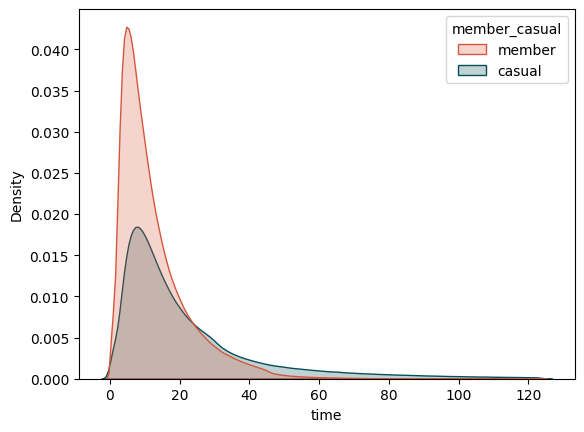

In [43]:
sns.kdeplot(data=cleaned2, x='time', hue='member_casual', fill=True)

On average, casual riders ride for 10 minutes longer than members, averaging 22 minutes a ride compared to the members' average of 12 minutes. This is apparent in the plot as well, with casual members taking a greater proportion of rides over 20 minutes. However, we can observe that this increased time is not a result of riding further as the distance rode by member and casual riders differ by a mere 4/100ths of a mile.

Let's look at the times of day and times of the year where member and casual riders take their rides:

<Axes: xlabel='count', ylabel='month'>

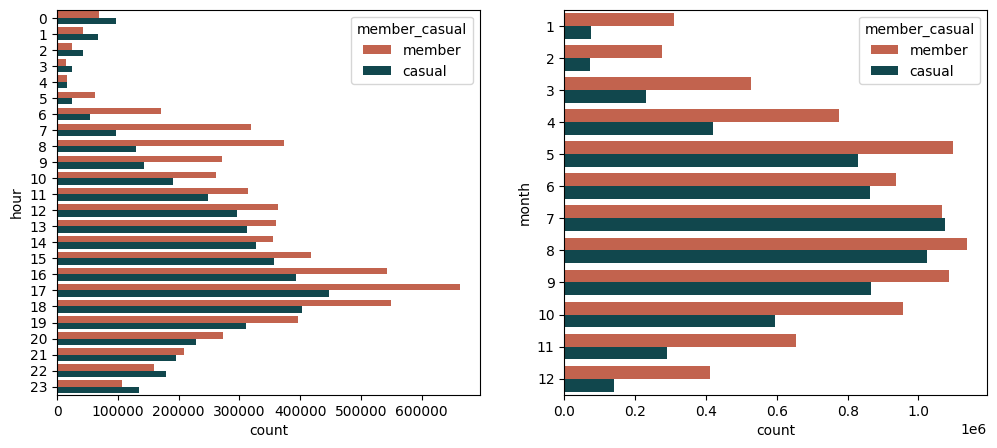

In [66]:
fig, axes = plt.subplots(1, 2, figsize=(12,5))
sns.countplot(data=cleaned2[cleaned2['year'].isin([2021,2022])], y='hour', hue='member_casual', ax=axes[0])
sns.countplot(data=cleaned2, y='month', hue='member_casual', ax=axes[1])

Casual riders tend to be more active in the early hours of the morning and the late hours of the evening. During more typical waking hours (4am-9pm), a greater proportion of the rides are from member riders. And because member riders make up a larger proportion of the rides, it is unsurprising that member rides outnumber casual rides for most months of the year. However, it is interesting to note that in July, casual rides exceed member rides. This is likely because, as the weather becomes warmer in the summer months, nonmembers are more inclined to bike around the city for transit, touring, and leisure.

Let's also compare the differences between stations for casual and member riders:

In [45]:
member_starting_count = cleaned2[cleaned2['member_casual']=='member']['start_station_name'].value_counts()
member_starting_count.sort_values(ascending=False)

start_station_name
Clark St & Elm St                              71600
Kingsbury St & Kinzie St                       68630
Wells St & Concord Ln                          64334
Wells St & Elm St                              57874
Broadway & Barry Ave                           54726
                                               ...  
Torrence Ave  & 106th St                           1
Public Rack - Kildare Ave & Washignton Blvd        1
Public Rack - Hale Ave & 111th St                  1
Public Rack - Pulaski & Rosemont                   1
Public Rack - Cottage Grove Ave & 111th St         1
Name: count, Length: 1682, dtype: int64

In [46]:
casual_starting_count = cleaned2[cleaned2['member_casual']=='casual']['start_station_name'].value_counts()
casual_starting_count.sort_values(ascending=False)

start_station_name
Streeter Dr & Grand Ave                153838
Millennium Park                         77606
Michigan Ave & Oak St                   69887
Theater on the Lake                     55878
Shedd Aquarium                          54993
                                        ...  
Park Manor Elementary School                1
Michigan Ave & 102nd St                     1
Public Rack - Langley Ave & 87th St         1
Pullman Community Center                    1
Public Rack - Avers & Granville             1
Name: count, Length: 1845, dtype: int64

<Axes: xlabel='count', ylabel='start_station_name'>

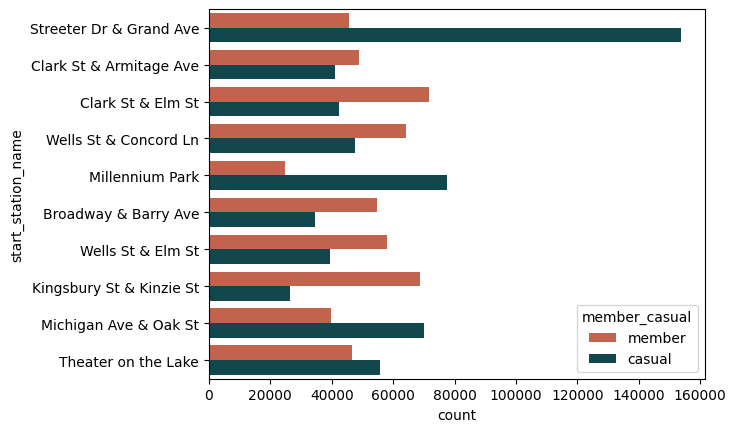

In [47]:
station_counts = cleaned2['start_station_name'].value_counts()
top_10_stations = cleaned2[cleaned2['start_station_name'].isin(station_counts.head(10).index)]
sns.countplot(data=top_10_stations, y='start_station_name', hue='member_casual')

In [48]:
station_coords = cleaned2.drop_duplicates(subset=['start_station_name'], keep='first') [['start_station_name','start_lat','start_lng']].set_index('start_station_name')
station_coords.head()

,start_lat,start_lng
start_station_name,,
Eckhart Park,41.8964,-87.6610
Drake Ave & Fullerton Ave,41.9244,-87.7154
McClurg Ct & Erie St,41.8945,-87.6179
California Ave & Division St,41.9030,-87.6975
Rush St & Hubbard St,41.8902,-87.6262


In [49]:
member_starting_count = member_starting_count.to_frame().join(station_coords)
casual_starting_count = casual_starting_count.to_frame().join(station_coords)

In [50]:
# px.scatter_geo(member_starting_count, lat='start_lat', lon='start_lng', hover_name=member_starting_count.index, size='count',title='member starting stations')

Most casual riders begin their rides at stations near lakeside tourist attractions, whereas member riders typically begin their rides in the city. For instance, Streeter Dr & Grand Ave (nearby Navy Pier), Millennium Park (nearby well, Millennium Park), and Michigan Ave & Oak St (nearby the Oak Street Beach) are the most-visited start stations for casual riders. On the other hand, the top four most-visited stations for member riders are in the Near North Side, closer to commercial districts than tourist attractions.

Let's do the same for end stations:

<Axes: xlabel='count', ylabel='end_station_name'>

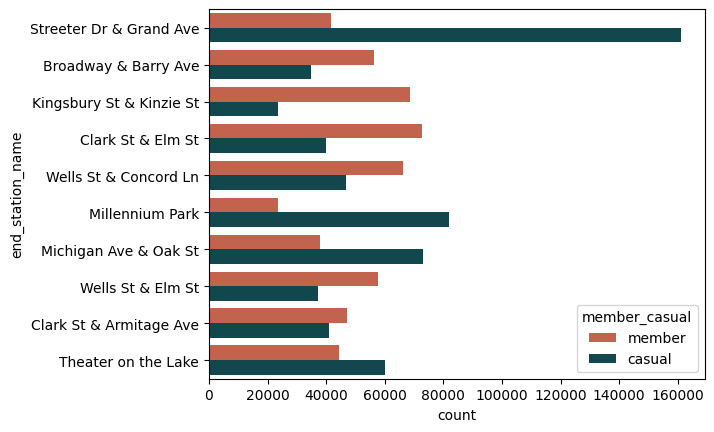

In [51]:
station_counts = cleaned2['end_station_name'].value_counts()
top_10_stations = cleaned2[cleaned2['end_station_name'].isin(station_counts.head(10).index)]
sns.countplot(data=top_10_stations, y='end_station_name', hue='member_casual')

The results seem to be more or less similar to the starting station data. However, note that this station analysis may exclude some data from electric bikes, as electric bikes need not be started or ended at an actual dock. Let's look at the data between casual and member riders in terms of only electric bikes:

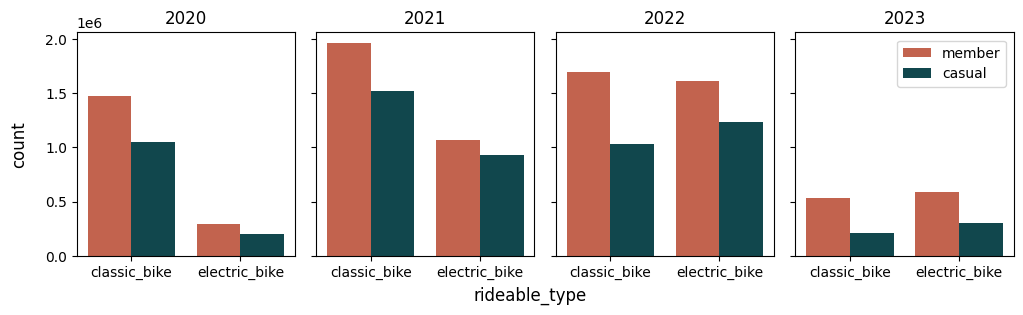

In [73]:
fig, axes = plt.subplots(1, 4, figsize=(10,3), sharey=True)

member_casual_palette = {'member': '#D5573B', 'casual': '#074F57'}
base_year = 2020
for i in range(4):
    sns.countplot(data=cleaned2[cleaned2['year']==base_year+i].sort_values('member_casual', ascending=False), x='rideable_type', hue='member_casual', palette=member_casual_palette, order=['classic_bike','electric_bike'], ax=axes[i])
    axes[i].set_title(str(base_year+i))
    # axes[i].tick_params(axis='x', labelrotation=45)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].legend_.remove()

fig.text(0.5, -0.02, 'rideable_type', ha='center', fontsize=12)
fig.text(-0.02, 0.5, 'count', va='center', rotation='vertical', fontsize=12)
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(0.983, 0.87))
fig.tight_layout()

There are some noteworthy trends to observe, particularly in relation to the proportion of classic bike usages to electric bike usages. There is a large shift from classic to electric bikes between 2021 and 2022 for both member and casual riders. In fact, there were more e-bike rides than classic bike rides from casual users in 2022. With the 2023 data up until May, this shift toward e-bike usage also appears to persist, with even member riders more frequently using electric bikes than classic bikes. Electric bikes were first introduced to the fleet at the end of July 2020, so it is interesting to observe its changes in popularity over the years. I will further examine this trend in the Inter-year analysis below.

#### Inter-year analysis

Divvy announced a change in its pricing structure in May 2022. Most notably, electric bikes, which were once free of charge to members for 45 minutes within certain zones, have become only free to unlock and cost 15 cents for each subsequent minute. Additionally, a \\$1 fee is assessed for docking the e-bike outside of a station. The prices have since increased to 17 cents per minute and \\$1.10 for out-of-station parking, but with these changes, it would be interesting to observe changes in members' behaviours, which we will do in this section.

Text(0.5, 1.0, '2022')

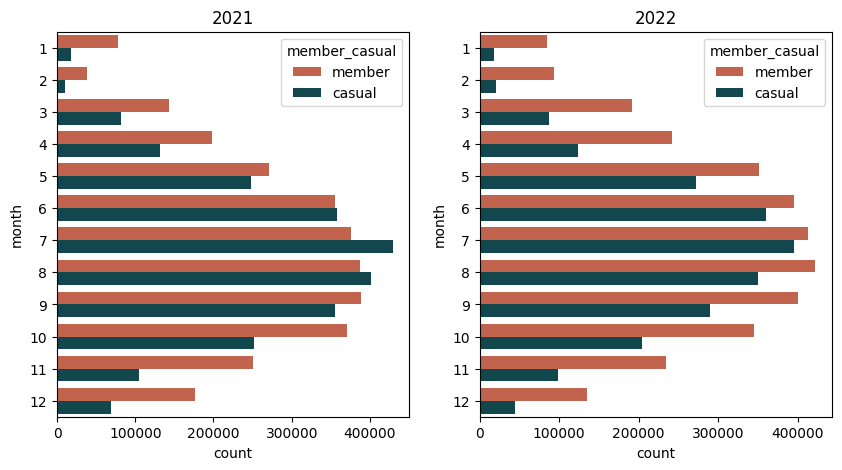

In [53]:
fig, axes = plt.subplots(1, 2, figsize=(10,5))
sns.countplot(data=cleaned2[cleaned2['year']==2021], y='month', hue='member_casual', ax=axes[0])
sns.countplot(data=cleaned2[cleaned2['year']==2022].sort_values('member_casual', ascending=False), y='month', hue='member_casual', ax=axes[1])
axes[0].set_title('2021')
axes[1].set_title('2022')

In [54]:
cleaned2['bike_year'] = cleaned2.apply(lambda row: str(row['year'])+'_'+row['rideable_type'].split('_')[0], axis=1)

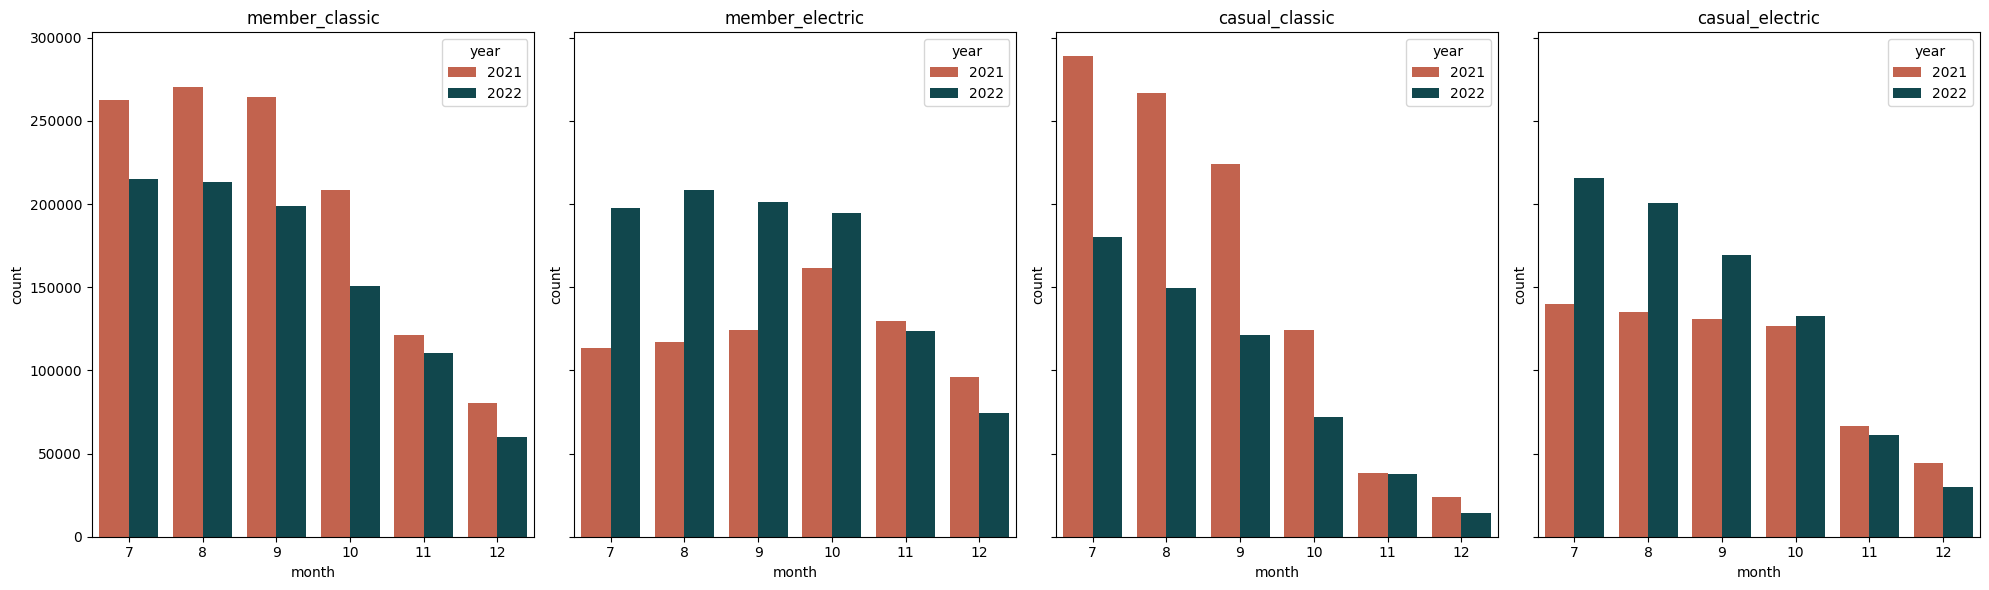

In [74]:
one_two = cleaned2['year'].isin([2021,2022])
classic = cleaned2['rideable_type']=='classic_bike'
electric = cleaned2['rideable_type']=='electric_bike'
member = cleaned2['member_casual']=='member'
casual = cleaned2['member_casual']=='casual'
after_june = cleaned2['month']>6

fig, axes = plt.subplots(1, 4, figsize=(20,6), sharey=True)

sns.countplot(data=cleaned2[classic & member & after_june & one_two], x='month', hue='year', ax=axes[0])
sns.countplot(data=cleaned2[electric & member & after_june & one_two], x='month', hue='year', ax=axes[1])
sns.countplot(data=cleaned2[classic & casual & after_june & one_two], x='month', hue='year', ax=axes[2])
sns.countplot(data=cleaned2[electric & casual & after_june & one_two], x='month', hue='year', ax=axes[3])
axes[0].set_title('member_classic')
axes[1].set_title('member_electric')
axes[2].set_title('casual_classic')
axes[3].set_title('casual_electric')
fig.tight_layout()

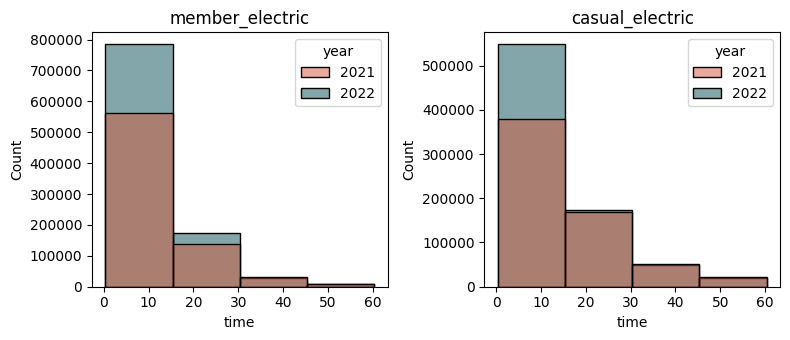

In [70]:
within_hour = cleaned2['time']<=60

fig, axes = plt.subplots(1, 2, figsize=(8,3.5))

sns.histplot(data=cleaned2[electric & member & after_june & one_two & within_hour], x='time', hue='year', binwidth=15, palette=colours[:2], multiple='layer', ax=axes[0])
sns.histplot(data=cleaned2[electric & casual & after_june & one_two & within_hour], x='time', hue='year', binwidth=15, palette=colours[:2], multiple='layer', ax=axes[1])
axes[0].set_title('member_electric')
axes[1].set_title('casual_electric')
fig.tight_layout()

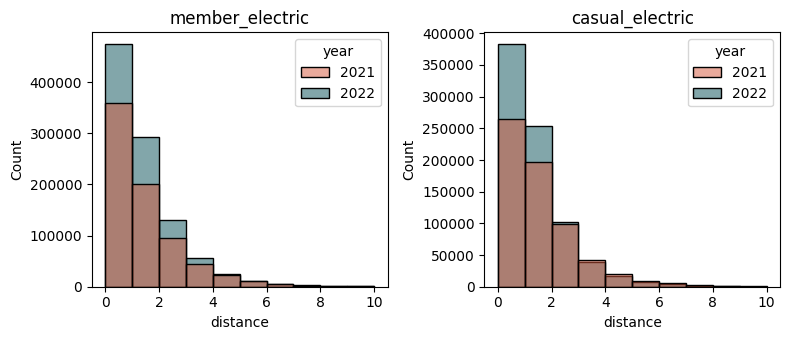

In [77]:
within_ten_miles = cleaned2['distance']<=10

fig, axes = plt.subplots(1, 2, figsize=(8,3.5))

sns.histplot(data=cleaned2[electric & member & after_june & one_two & within_ten_miles], x='distance', hue='year', binwidth=1, palette=colours[:2], multiple='layer', ax=axes[0])
sns.histplot(data=cleaned2[electric & casual & after_june & one_two & within_ten_miles], x='distance', hue='year', binwidth=1, palette=colours[:2], multiple='layer', ax=axes[1])
axes[0].set_title('member_electric')
axes[1].set_title('casual_electric')
fig.tight_layout()

The results here are quite surprising. Despite the price increase of electric bikes, both member and casual users alike turned away from classic bikes toward the e-bikes, especially in the warmer months. Furthermore, the increased usage of e-bikes is mostly for rides that are under 45 minutes. Because only the per-minute cost is comparatively higher relative to classic bikes for casual users, it is not too surprising that casual users may choose to use an electric bike for their shorter commutes. On the other hand, I find it somewhat unexpected that many of the increased e-bike usage by members are less than 30 minutes, with most of the increase accounted for by rides less than 15 minutes, considering that members are able to ride free for the first 45 minutes on a classic bike. Rather than the slightly over double per minute of usage that casual riders take on, member riders can often completely avoid the charge that comes along with an electric bike by taking a classic bike instead. 

Aside from the reduced effort that cruising on an e-bike requires compared to riding a hefty, classic bike (which is extremely valid, particularly on those humid summer days), this phenomenon may be the result of station availability. Because e-bikes can be locked to any public bike rack and do not need to be docked at an official Divvy dock as classic bikes are required to, the additional costs of taking an e-bike may be reasonable for the member rider who may not want to go out of their way to dock a classic bike at Divvy dock, especially for a quick commute. This may also explain why the increase in e-bikes arises largely from a higher prevalence of trips under 5 miles. I will further examine this phenomenon in the Inter-station analysis section below.

Another part of the reason for this increase in e-bike usage may be the increase in availability of e-bikes after their launch in late-2020. If additional e-bike availability data were accessible, it would be interesting to observe the trend toward electric bikes after controlling for their increased availability.

#### Inter-station analysis

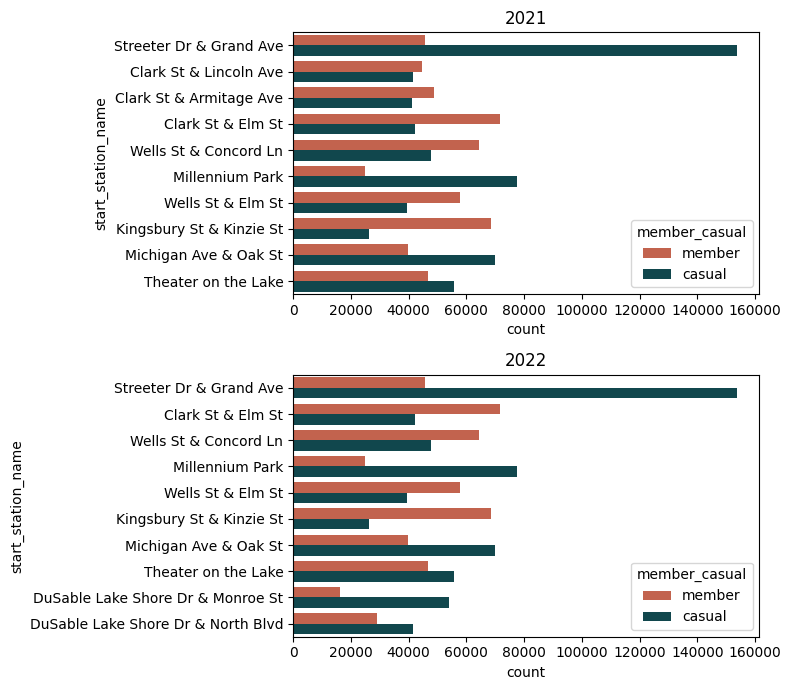

In [87]:
station_counts_21 = cleaned2[cleaned2['year']==2021]['start_station_name'].value_counts()
top_10_stations_21 = cleaned2[cleaned2['start_station_name'].isin(station_counts_21.head(10).index)]
station_counts_22 = cleaned2[cleaned2['year']==2022]['start_station_name'].value_counts()
top_10_stations_22 = cleaned2[cleaned2['start_station_name'].isin(station_counts_22.head(10).index)]

fig, axes = plt.subplots(2, 1, figsize=(8,7))

sns.countplot(data=top_10_stations_21, y='start_station_name', hue='member_casual', ax=axes[0])
sns.countplot(data=top_10_stations_22, y='start_station_name', hue='member_casual', ax=axes[1])
axes[0].set_title('2021')
axes[1].set_title('2022')
fig.tight_layout()

Between 2021 and 2022, there is a small change in the top ten most-used stations. The stations with the highest utilisations, for either member or casual users, in 2021 nevertheless remain highly utilised in 2022. How does this result change when we consider only electric bikes?

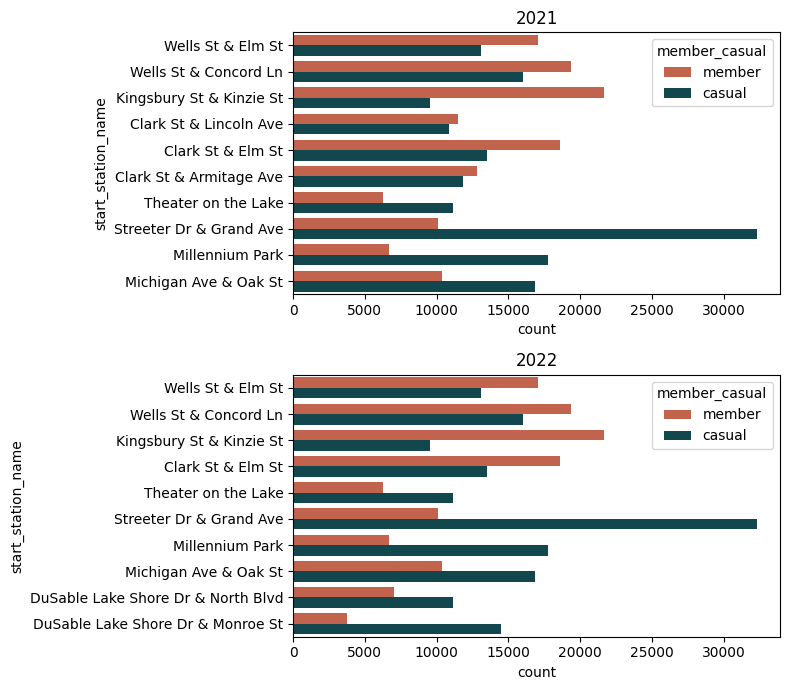

In [90]:
fig, axes = plt.subplots(2, 1, figsize=(8,7))

sns.countplot(data=cleaned2[cleaned2['start_station_name'].isin(station_counts_21.head(10).index) & electric], y='start_station_name', hue='member_casual', ax=axes[0])
sns.countplot(data=cleaned2[cleaned2['start_station_name'].isin(station_counts_22.head(10).index) & electric], y='start_station_name', hue='member_casual', ax=axes[1])
axes[0].set_title('2021')
axes[1].set_title('2022')
fig.tight_layout()

The electric bike starting station popularity roughly mimicks that of the overall starting station popularity, which is not a big surprise. But that's quite a small number of records...

In [110]:
one = cleaned2['year']==2021
two = cleaned2['year']==2022

one_missing_start = cleaned2[one & electric]['start_station_name'].isna().sum()
two_missing_start = cleaned2[two & electric]['start_station_name'].isna().sum()
one_missing_end = cleaned2[one & electric]['end_station_name'].isna().sum()
two_missing_end = cleaned2[two & electric]['end_station_name'].isna().sum()
one_len = cleaned2[one & electric].shape[0]
two_len = cleaned2[two & electric].shape[0]

print('{} of {} ({:.2f}%) records with null starting stations in 2021'.format(one_missing_start, one_len, 100*one_missing_start/one_len))
print('{} of {} ({:.2f}%) records with null starting stations in 2022'.format(two_missing_start, two_len, 100*two_missing_start/two_len))
print('{} of {} ({:.2f}%) records with null ending stations in 2021'.format(one_missing_end, one_len, 100*one_missing_end/one_len))
print('{} of {} ({:.2f}%) records with null ending stations in 2022'.format(two_missing_end, two_len, 100*two_missing_end/two_len))

676101 of 2002384 (33.76%) records with null starting stations in 2021
816282 of 2846213 (28.68%) records with null starting stations in 2022
711278 of 2002384 (35.52%) records with null ending stations in 2021
862018 of 2846213 (30.29%) records with null ending stations in 2022
